<a href="https://colab.research.google.com/github/aryanshu/NLP/blob/master/Fine_Tuning_of_bert_for_query_context_relevance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
cd "/gdrive/My Drive/Colab Notebooks"

/gdrive/My Drive/Colab Notebooks


In [0]:
import pandas as pd
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.metrics import accuracy_score

In [0]:
df=pd.read_csv('f_train2')

In [5]:
df.head()

,Unnamed: 0,index,context,label,question
0,0,0,"Architecturally, the school has a Catholic cha...",1,To whom did the Virgin Mary allegedly appear i...
1,1,1,"Architecturally, the school has a Catholic cha...",1,What is in front of the Notre Dame Main Building?
2,2,2,"Architecturally, the school has a Catholic cha...",1,The Basilica of the Sacred heart at Notre Dame...
3,3,3,"Architecturally, the school has a Catholic cha...",1,What is the Grotto at Notre Dame?
4,4,4,"Architecturally, the school has a Catholic cha...",1,What sits on top of the Main Building at Notre...


In [0]:
df=df[:60000]

In [0]:
df= df.sample(frac=1).reset_index(drop=True)

In [0]:
df_n=df[55000:60000]
df=df[:55000]

In [0]:
df=df[:10000]

In [10]:
import torch
if torch.cuda.is_available():   
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [12]:
!pip install transformers

     |████████████████████████████████| 450kB 4.8MB/s 
     |████████████████████████████████| 870kB 11.8MB/s 
     |████████████████████████████████| 1.0MB 37.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=4ed0c86fef1c455a6ed3dcf9ee409dd09ef0a65dc31e09758f6b68ef988719fe
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [13]:
from transformers import BertTokenizer

In [0]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
sent1=df.context.values
sent2=df.question.values
labels=df.label.values


In [16]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()

,index,context,label,question
0,7462,The top 10 contestants started with five males...,1,How many contestants did this season have?
1,120,"On 15 October 1969, while paying a visit to th...",0,What was the size of the Notre Dame endowment ...
2,15325,The last use of the firing squad between 1608 ...,0,What does management of canon law aim to regul...
3,37573,"At birth, Victoria was fifth in the line of su...",1,What was Victorias place in line of succession...
4,11036,The 2013 Human Development Report by the Unite...,1,Which year was used for estimates in the 2013 ...


In [17]:
df.drop(['index'],axis=1,inplace=True)
df.head()

,context,label,question
0,The top 10 contestants started with five males...,1,How many contestants did this season have?
1,"On 15 October 1969, while paying a visit to th...",0,What was the size of the Notre Dame endowment ...
2,The last use of the firing squad between 1608 ...,0,What does management of canon law aim to regul...
3,"At birth, Victoria was fifth in the line of su...",1,What was Victorias place in line of succession...
4,The 2013 Human Development Report by the Unite...,1,Which year was used for estimates in the 2013 ...


In [18]:
input_ids = []
tokenize_text=[]
for i in range(len(sent1)):

    encoded_sent = tokenizer.encode(
                        sent1[i],
                        sent2[i],                     
                        add_special_tokens = True, 
                        max_length=256
            
                   )
    input_ids.append(encoded_sent)

print('Original: ', sent1[0],sent2[0])
print('Token IDs:', input_ids[0])

      


Original:  The top 10 contestants started with five males and five females, however, the males were eliminated consecutively in the first five weeks, with Lazaro Arbos the last male to be eliminated. For the first time in the show's history, the top 5 contestants were all female. It was also the first time that the judges' "save" was not used, the top four contestants were therefore given an extra week to perform again with their votes carried over with no elimination in the first week. How many contestants did this season have?
Token IDs: [101, 1996, 2327, 2184, 10584, 2318, 2007, 2274, 3767, 1998, 2274, 3801, 1010, 2174, 1010, 1996, 3767, 2020, 5892, 5486, 2135, 1999, 1996, 2034, 2274, 3134, 1010, 2007, 2474, 9057, 2080, 12098, 15853, 1996, 2197, 3287, 2000, 2022, 5892, 1012, 2005, 1996, 2034, 2051, 1999, 1996, 2265, 1005, 1055, 2381, 1010, 1996, 2327, 1019, 10584, 2020, 2035, 2931, 1012, 2009, 2001, 2036, 1996, 2034, 2051, 2008, 1996, 6794, 1005, 1000, 3828, 1000, 2001, 2025, 2109, 

In [19]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 256
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

Using TensorFlow backend.


In [0]:

attention_masks = []


for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [0]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [24]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    elapsed_rounded = int(round((elapsed)))
    
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

model.zero_grad()


for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

   
        model.train()
 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()



    avg_train_loss = total_loss / len(train_dataloader)            
    
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()


    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0


    for batch in validation_dataloader:
        

        batch = tuple(t.to(device) for t in batch)
        
   
        b_input_ids, b_input_mask, b_labels = batch
        

        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    torch.save(model.state_dict(), "models/sent_bert2.pth")

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    563.    Elapsed: 0:00:18.
  Batch    80  of    563.    Elapsed: 0:00:36.
  Batch   120  of    563.    Elapsed: 0:00:54.
  Batch   160  of    563.    Elapsed: 0:01:12.
  Batch   200  of    563.    Elapsed: 0:01:30.
  Batch   240  of    563.    Elapsed: 0:01:47.
  Batch   280  of    563.    Elapsed: 0:02:05.
  Batch   320  of    563.    Elapsed: 0:02:23.
  Batch   360  of    563.    Elapsed: 0:02:41.
  Batch   400  of    563.    Elapsed: 0:02:59.
  Batch   440  of    563.    Elapsed: 0:03:17.
  Batch   480  of    563.    Elapsed: 0:03:34.
  Batch   520  of    563.    Elapsed: 0:03:52.
  Batch   560  of    563.    Elapsed: 0:04:10.

  Average training loss: 0.08
  Training epcoh took: 0:04:11

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:09

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    563.    Elapsed: 0:00:18.
  Batch    80  of    563.    Elapsed: 0:00:36.
  Batch   120  of    563.    Elap

In [33]:
labels

array([1, 0, 0, ..., 1, 0, 0])

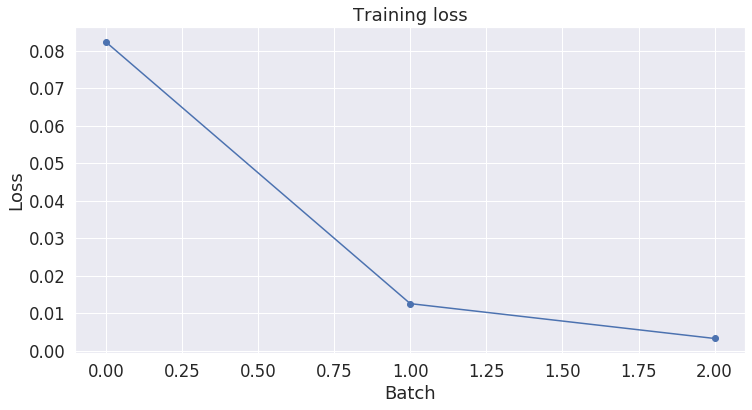

In [34]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.show()

##EVALUATING ON TEST SET

In [35]:
model_t = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_t.cuda()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# loading saved model

import torch
model2=torch.load("models/sent_bert2.pth")

In [0]:
#df_n.drop(['Unnamed: 0','index'],axis=1,inplace=True)
sent1=df_n.context.values
sent2=df_n.question.values
labels=df_n.label.values

input_ids = []

tokenize_text=[]
for i in range(len(sent1)):

    encoded_sent = tokenizer.encode(
                        sent1[i],
                        sent2[i],                     
                        add_special_tokens = True, 
                        max_length=256
            
                   )
    input_ids.append(encoded_sent)


from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 256
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

batch_size = 16

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [39]:
model_t.load_state_dict(model2)

<All keys matched successfully>

In [40]:
model_t.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [41]:
model_t.eval()
 
predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [0]:
pred1=predictions

In [43]:
pred2=[]
for i in range(len(true_labels)):
  pred= np.argmax(pred1[i], axis=1).flatten()
  pred2=pred2+pred.tolist()

pred2

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [44]:
pred2=np.asarray(pred2)
true_labels[1]

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
t3=[]
for i in range(len(true_labels)):
  t2= true_labels[i]
  t3=t3+t2.tolist()

In [46]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score 
acc=accuracy_score(pred2,t3)
f1=f1_score(pred2,t3)
precision=precision_score(pred2,t3)
recall=recall_score(pred2,t3)
print(" accuracy={} \n f1={} \n precision={} \n recall={}".format(acc,f1,precision,recall))

 accuracy=0.9916 
 f1=0.9936150805716023 
 precision=0.9927095990279465 
 recall=0.9945222154595252
